# Settings

In [3]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import soundfile as sf
import utils

# plt.rcParams["figure.figsize"] = (5,5)
# plt.rc('font', size=20)
# plt.rc('axes', labelsize=25)
# plt.rc('xtick', labelsize=25)
# plt.rc('ytick',labelsize=25)
# plt.rc('legend', fontsize=20)
# plt.rc('figure', titlesize=50)
# plt.rc('figure', autolayout=True)

sr = 16000
win_time = 0.02
dftlen = 512
# Window Sample의 길이 표현
win_len = int(win_time * sr)
hop_len = int(win_len * 0.5)
print("Window Len:",win_len)
print("Hop Len:",hop_len)


Window Len: 320
Hop Len: 160


## Windowing and Overlapping

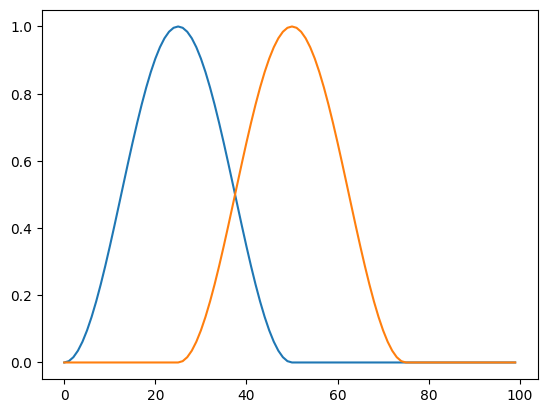

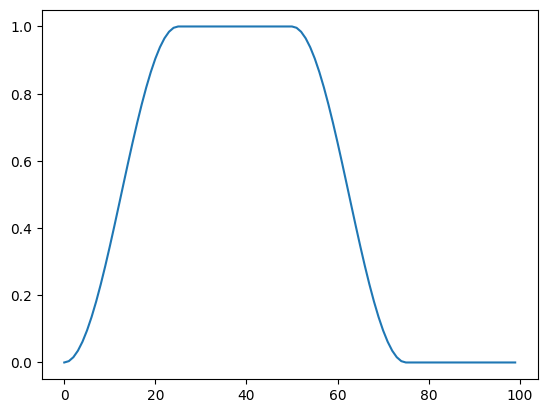

In [4]:
## Overlap Test

h = lr.filters.get_window(window="hann", Nx=50)
z = np.zeros_like(h)
h = np.concatenate([h,z])
h2 = np.roll(h,25)
plt.plot(h)
plt.plot(h2)
plt.show()

# h3 = h+h2+np.roll(h2,25)
h3 = h+h2
# print(h3)
plt.plot(h3)
plt.show()


### OLA를 하려면 hamming은 1.08배 scale이 되어야 하는구나!

Loaded: sa0_new.wav, Shape: (8200,), Original sr: 16000


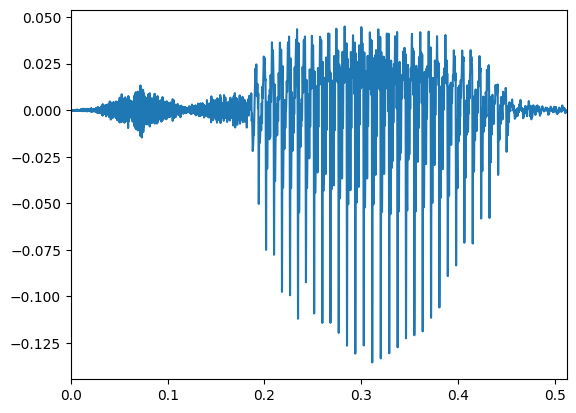

In [5]:
###
### Read input waves
# file_path = "yonseicrop.wav"
file_path = 'sa0_new.wav'

### Read Audio Files
yr,ori_sr = lr.load(file_path,sr=sr)
print(f"Loaded: {file_path}, Shape: {np.array(yr).shape}, Original sr: {ori_sr}")
    
# Time axis
time = np.linspace(0,len(yr),len(yr),endpoint=False)/sr
plt.plot(time,yr)
# plt.plot(yr)
# plt.ylim(bottom=-0.135, top=0.05)
plt.xlim(0,time[-1])
plt.show()



hann
From 8200 samples, total 50 frames are generated


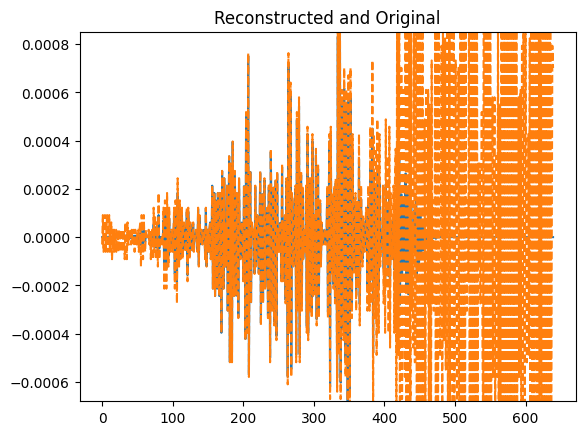

In [6]:
### Frame Extractor
### Extract frames by windowing

FE = utils.FrameExtractor(yr,win_len,hop_len)
frame_arr = FE.extract_frames(win_type="hann")

# plt.plot(frame_arr[0])
# plt.plot(frame_arr[1])
# plt.show()

x = np.concatenate([frame_arr[0],np.zeros_like(frame_arr[0])])
y = np.concatenate([frame_arr[1],np.zeros_like(frame_arr[1])])
y = np.roll(y,hop_len)
z = x+y / 1.08

plt.plot(z)
plt.ylim(np.min(z),np.max(z))

# plt.show()
plt.plot(yr[:win_len*2],'--')
plt.ylim(np.min(z),np.max(z))
plt.title("Reconstructed and Original")
plt.show()

startind: 0


startind: 160
startind: 320
startind: 480
startind: 640


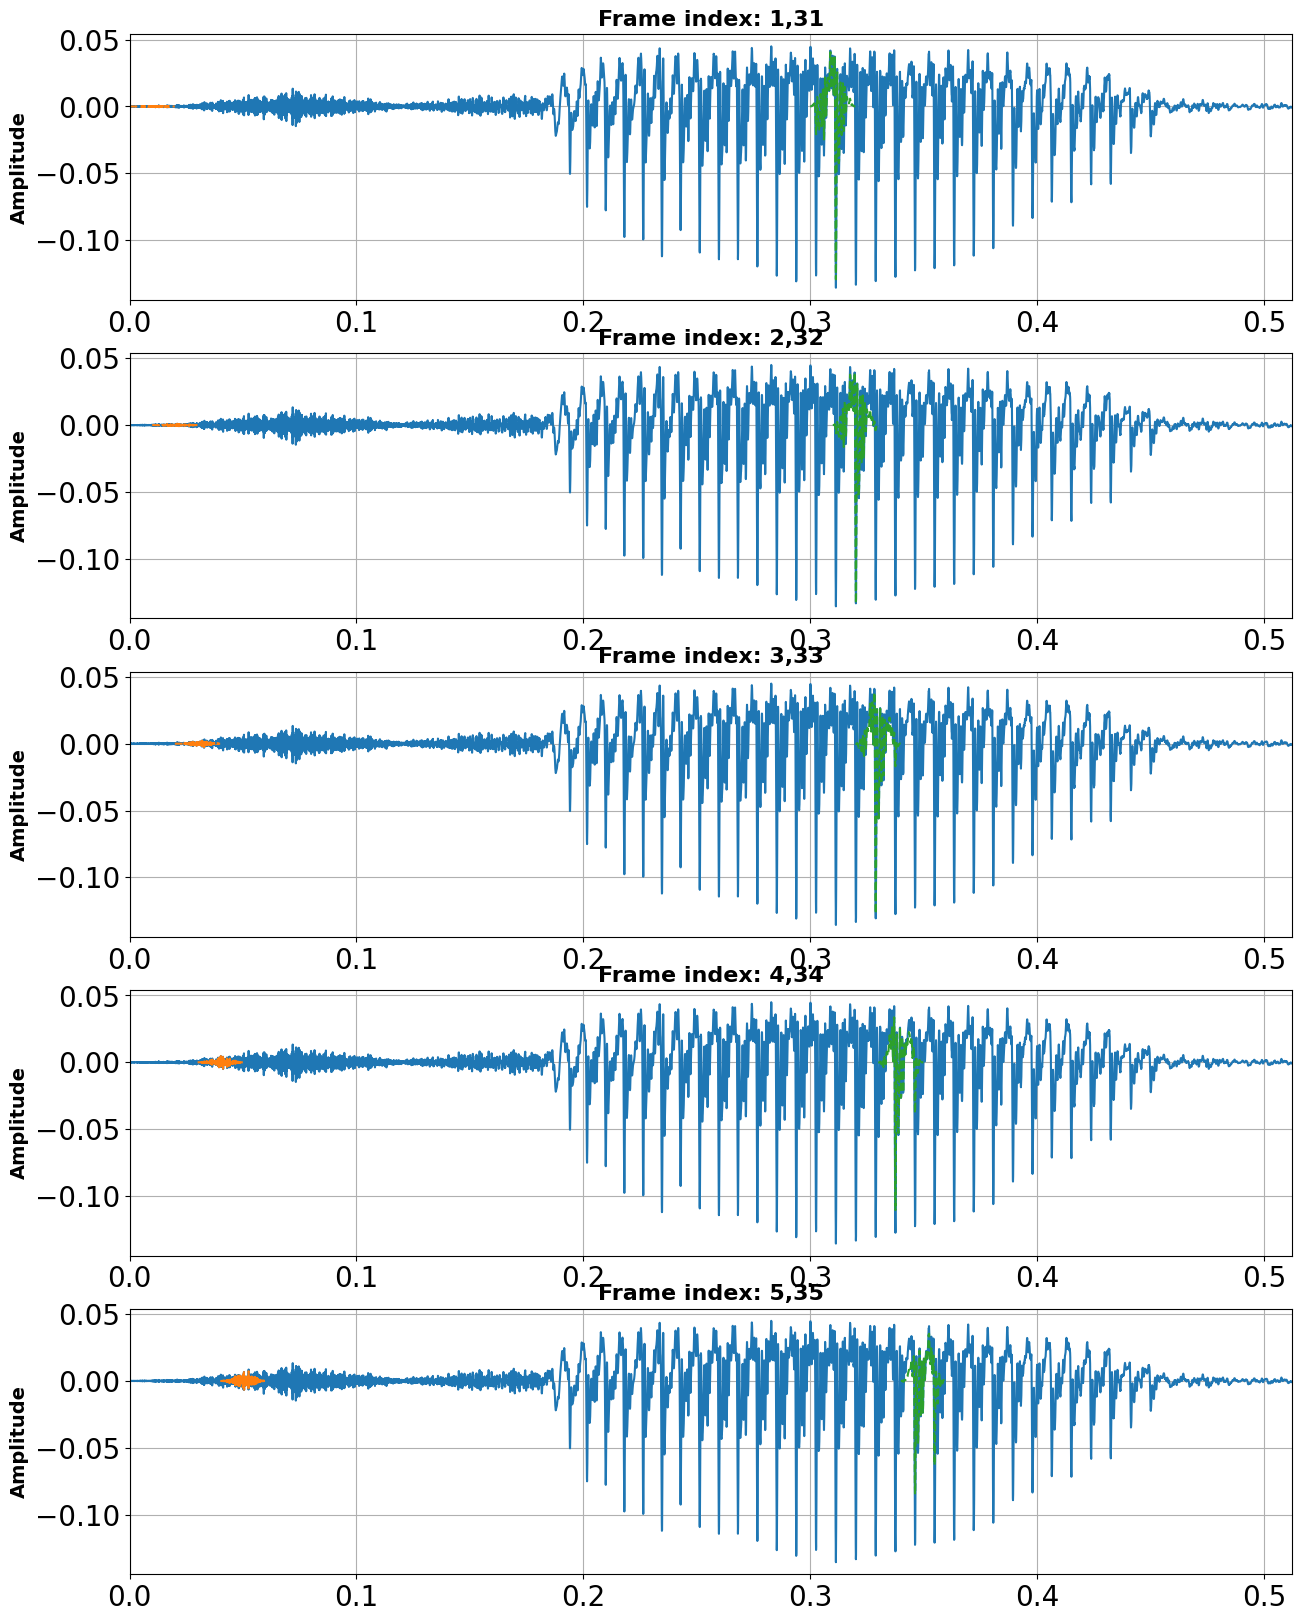

In [7]:
## 0번 frame 부터 5개를 표시해보자
ind1 = 0
ind2 = 30
fig, axes = plt.subplots(5,1,figsize=(15,20))

time = np.arange(0, len(yr)/sr, 1/sr)
for i in range(5):
    startind1 = FE.hop_len * ind1
    endind1 = FE.hop_len * ind1 + FE.win_len
    startind2 = FE.hop_len * ind2
    endind2 = FE.hop_len * ind2 + FE.win_len
    print("startind:", startind1)
    frame1 = frame_arr[ind1]
    frame2 = frame_arr[ind2]
    ind1 += 1
    ind2 += 1

    # 기존 waveform 그리기
    axes[i].plot(time, yr, label='waveform')
    
    # 추출된 frame 그리기
    axes[i].plot(time[startind1: endind1], frame1, label='frame {}'.format(2*i + 1), linestyle='--')
    axes[i].plot(time[startind2: endind2], frame2, label='frame {}'.format(2*i + 2), linestyle='--')
    
    # axes[i].set_xlabel('Time(s)', fontsize=18, fontweight='bold')
    axes[i].set_ylabel('Amplitude', fontsize=14, fontweight='bold')
    axes[i].set_title('Frame index: {},{}'.format(ind1, ind2), fontsize=16, fontweight='bold')
    axes[i].tick_params(axis='both', labelsize=20)
    axes[i].set_xlim(0, time[-1])

    # axes[i].legend(fontsize=20,loc='lower left')
    axes[i].grid()
    
    # plt.figure(figsize=[15,6])
    # plt.subplot(2,2,1)
    # plt.plot(frame1)
    # plt.grid()
    # plt.xlim(0,len(frame1)-1)
    # plt.title("Unvoiced")
    # plt.xlabel("Samples")
    # plt.subplot(2,2,2)
    # plt.plot(frame2)
    # plt.grid()
    # plt.xlim(0,len(frame2)-1)
    # plt.title("voiced")
    # plt.xlabel("Samples")

# plt.tight_layout()  # subplot 간의 간격 조절
plt.show()


In [8]:
## 각 frame 에서의 autocorrelation 계산 해보기

def auto_corr(signal):
    corr = np.correlate(signal, signal, mode='full')
    corr = corr[len(corr)//2:]
    return corr 

# 각 frame 속에서 p차 LPC 계수의 계수를 반환한다
def LPC(frame, order=10):
    coeff_arr = np.zeros(order)
    
    ## Auto Correlation of frame
    # error
    if len(frame) < order:
        print('frame is longer than order')
        return -1
    
    # 좌변
    ac = auto_corr(frame)[:order]
    mat_T = make_toeplitz(ac)
    # print(mat_T)

    # 우변
    vec_b = auto_corr(frame)[1:order+1]
    coeff_arr  = np.dot(np.linalg.inv(mat_T),vec_b)
    return coeff_arr

def make_toeplitz(ac):
    p = len(ac)
    toeplitz_mat = np.zeros((p,p))
    ac_flip = ac[::-1][:-1]
    
    for i in range(p):
        # print(ac[:p-i])
        # print(ac_flip[p-i-1:])
        # print("iter")
        toeplitz_mat[i,:] = np.concatenate((ac_flip[p-i-1:],ac[:p-i]))
        

    return toeplitz_mat

def generate_impulse(freq,sr,duration):
    t = np.arange(0,duration, 1/sr)
    impulse = np.sin(2 * np.pi * freq * t)
    return impulse

def derbin(r, order):
    
    # r : 1-D auto corr array
    a = np.zeros((order+1,order+1))
    
    # store prediction error for each step
    E = np.zeros(order+1)
    
    # First coeff
    a[0][0] = 1
    
    # Initial prediction error : power
    E[0] = r[0]
    
    # iterate from 1 to order p 
    for i in range(1,order+1):
        sum_j = sum(a[i-1][j] * r[i-j] for j in range(1,i))
        k_i = (r[i] - sum_j ) / E[i-1]
        
        # Update coefficeints for current step
        a[i][i] = k_i
        for j in range(1,i):
            a[i][j] = a[i-1][j] - k_i * a[i-1][i-j]
            
        #Update Error
        E[i] = (1-k_i**2) * E[i-1]
        # print("i={}, ki={}".format(i,k_i))
    # Extract final coeff, exclude a0    
    coeff = a[order][1:]
    return coeff,E

# Derbin's Algorithm
def myderbin(r, p):
    E = np.zeros(p+1)
    a = np.zeros((p+1,p+1))
    
    a[0][0] = 1
    E[0] = r[0]

    for i in range(1,p+1):
        # 현재 order == i

        ## sigma
        j=1
        sumj = 0
        while(j <= i-1):
            sumj+=a[i-1][j]*r[i-j]
            j += 1
        
        k_i = (r[i] - sumj) / E[i-1] 
        a[i][i] = k_i

        ## i-order 새로운 coeff 갱신
        for j in range(1,i):
            a[i][j] = a[i-1][j] - k_i * a[i-1][i-j]
            
        E[i] = (1 - k_i**2)*E[i-1]
        # print("i={}, ki={}".format(i,k_i))
        
        coeff = a[p][1:]
    return coeff,E



# 예제 자동 상관 함수
auto_corr_sequence = np.array([0, 1, 2, 3,4,5])

# Toeplitz 행렬 생성
# toeplitz_result = make_toeplitz(auto_corr_sequence)
# print(LPC([1,2,34,5,6,7,8],order=6))

# print(len(frame_arr))

########################## LPC on every frames
# frame_len = len(frame_arr)
# coeff_arr = []
# # print(frame_len, len(coeff_arr))
# for ind,frame in enumerate(frame_arr):
#     # 매 frame에서 LPC 계수 계산
#     coeff = LPC(frame,order=10)
#     coeff_arr.append(coeff) 
#     break
y = frame_arr[30]

derbin(auto_corr(y),3)
print("\n")
myderbin(auto_corr(y),3)

(array([ 1.84509583, -0.9188547 ,  0.00520664]),
 array([0.15912782, 0.01127945, 0.00195386, 0.00195381]))

In [9]:
# ### librosa의 LPC와 비교하는 것

# import matplotlib.pyplot as plt
# import scipy
# y, sr = lr.load(lr.ex('libri1'), duration=0.020)

# y = yr
# s = 16000
# a = lr.lpc(y, order=5)
# b = np.hstack([[0], -1 * a[1:]])
# print(a)
# print(b)

# mya = LPC(y, order=5)
# myb = np.hstack([[0],mya[:]])
# print(mya)
# print(myb)

# myy = scipy.signal.lfilter(myb, [1], y)
# y_hat = scipy.signal.lfilter(b, [1], y)
# fig, ax = plt.subplots()
# ax.plot(y)
# # ax.plot(y_hat, linestyle='--')
# ax.plot(myy ,label="mine")
# ax.legend(['y', 'y_hat'])
# ax.set_title('LP Model Forward Prediction')

In [10]:
### librosa의 LPC와 비교하는 것
import librosa
import matplotlib.pyplot as plt
import scipy
y = frame_arr[30]

a = librosa.lpc(y, order=3)
print(a)
mya = LPC(y, order=3)
drbina,e1 = derbin(auto_corr(y),order=3)
mydrbina,e2 = myderbin(auto_corr(y), p=3)

print("librosa LPC: \t\t", -1*a[1:])
print("Matrix Inverse: \t", mya)
print("Derbin's Inverse: \t", drbina)
print("myDerbin's Inverse: \t", mydrbina)


[ 1.         -1.8450958   0.91885465 -0.00520662]
librosa LPC: 		 [ 1.8450958  -0.91885465  0.00520662]
Matrix Inverse: 	 [ 1.84509583 -0.9188547   0.00520664]
Derbin's Inverse: 	 [ 1.84509583 -0.9188547   0.00520664]
myDerbin's Inverse: 	 [ 1.84509583 -0.9188547   0.00520664]


[ 1.         -2.26700912  1.53569368 -0.93015915  2.4764771  -3.01438386
  1.67110756 -1.16275743  1.67230516 -1.54589766  0.66601324 -0.05369273
 -0.03347511]


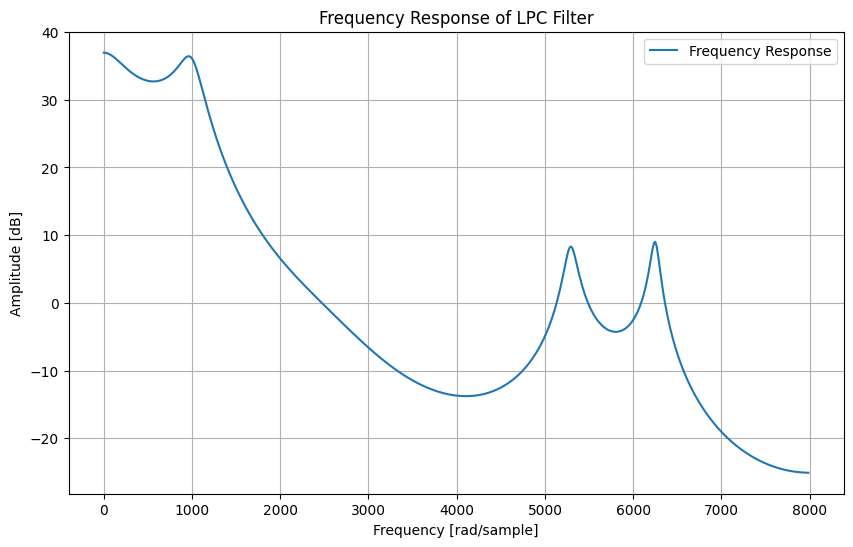

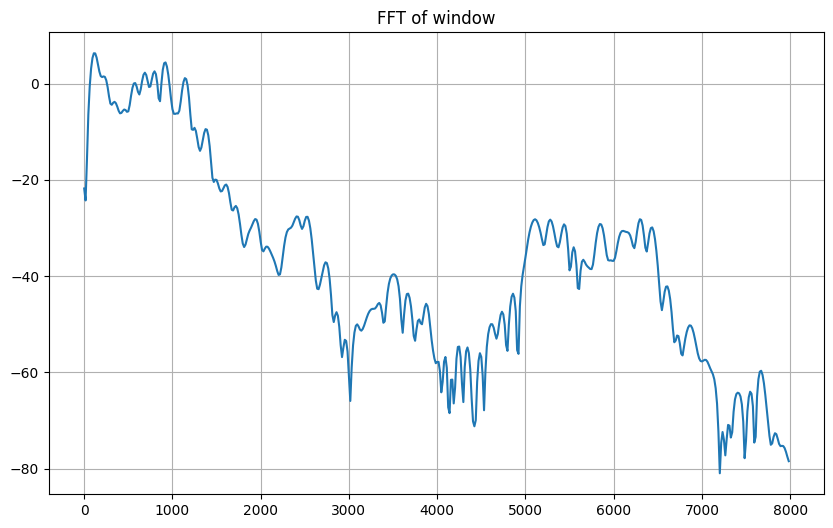

512
512


In [11]:
##
## Filter의 Vocal Tract Response 추정해보기

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz, hamming, lfilter_zi, lfiltic
from scipy.linalg import toeplitz, inv

## GPT의 LPC 
def lpc_analysis(signal, order=10):
    """주어진 신호에 대한 LPC 계수를 계산합니다."""
    # 자기상관 함수 계산
    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # 토플리츠 행렬 및 벡터 준비
    R = toeplitz(autocorr[:order])
    
    r = autocorr[1:order+1]
    
    # LPC 계수 계산 (Levinson-Durbin 알고리즘)
    lpc_coeffs = np.dot(inv(R), r)
    lpc_coeffs = np.insert(lpc_coeffs, 0, 1)  # LPC 계수에 1 추가
    return lpc_coeffs

# 예제 신호 생성 (예: 사인파)
fs = 8000  # 샘플링 주파수
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)
signal = frame_arr[30]

# LPC 분석
order = 12  # LPC 계수의 수
a = LPC(signal, order=order)
a = np.concatenate(([1],-a))
print(a)
w, h = freqz(b=[1], a=a)

sr = 16000
# w축을 0-0.5Fs 로 정규화
w = w /np.pi * 0.5 * sr
# 주파수 응답 시각화
plt.figure(figsize=(10, 6))
plt.plot(w, 20 * np.log10(abs(h)), label='Frequency Response')
plt.title('Frequency Response of LPC Filter')
plt.xlabel('Frequency [rad/sample]')
plt.ylabel('Amplitude [dB]')
plt.grid(True)
plt.legend()
plt.show()

ff = np.fft.fft(signal,1024)
ff = np.fft.fftshift(ff)
ff = ff[len(ff)//2:]
# ff = np.abs(ff)
plt.figure(figsize=(10, 6))
plt.plot(w,20 * np.log10(abs(ff)))
plt.grid()
plt.title("FFT of window")
plt.show()


print(len(ff))
print(len(w))

[ 1.         -2.21546278  1.37811592 -0.76798206  2.4117717  -2.88092029
  1.35525389 -0.95221124  1.65754695 -1.40002589  0.4308214 ]


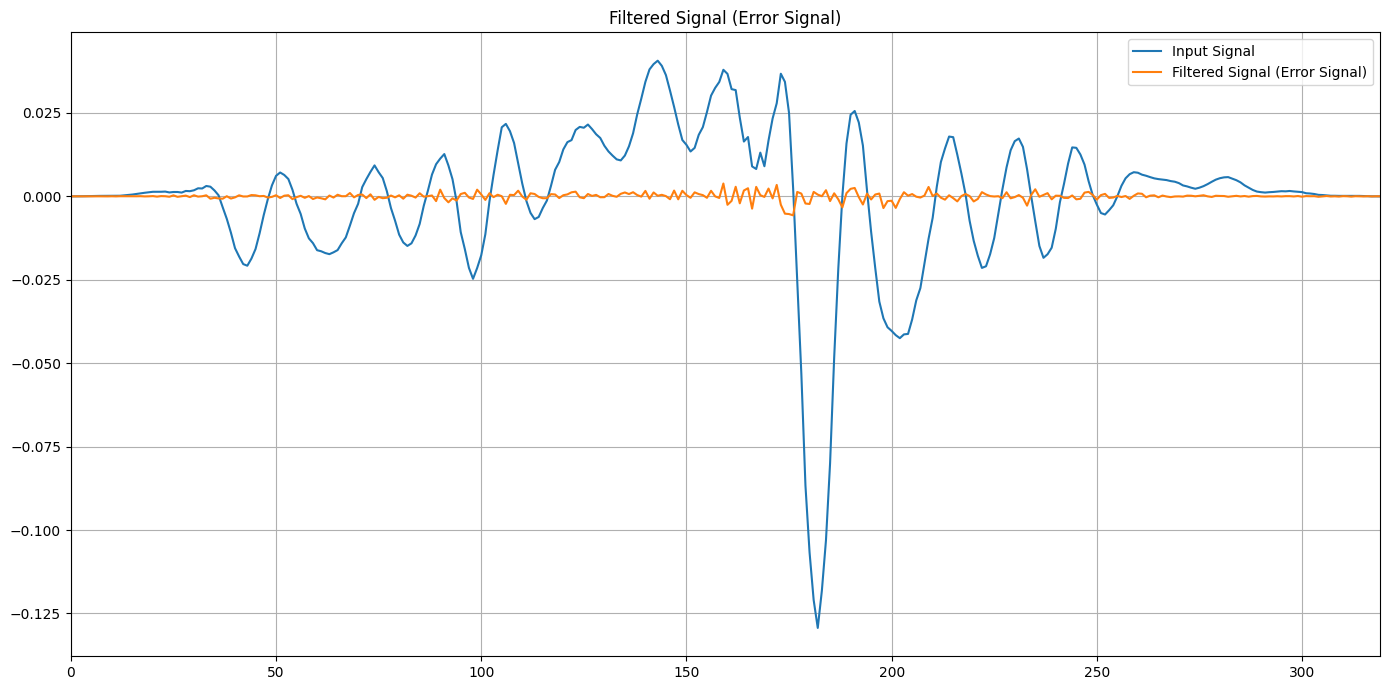

In [12]:
## 주어진 input 신호와, 에러 신호를 그려봅시다
## Error 신호 그리기

signal = frame_arr[30]
order = 10

# LPC Analysis
coeff = LPC(signal, order=10)

# Error 전달함수의 계수
coeff_T = np.concatenate(([1],-coeff))
# tt = lr.lpc(signal,order=order)
# print(tt)
print(coeff_T)

filtered = lfilter(coeff_T,[1],signal)

# 입력 신호와 에러 신호(필터링된 신호) 그리기
plt.figure(figsize=(14, 7))

# 입력 신호 플롯
# plt.subplot(2, 1, 1)
plt.plot(signal, label='Input Signal')
plt.title('Input Signal')
plt.grid(True)
plt.xlim(0,len(signal)-1)
plt.legend()

# 에러 신호(필터링된 신호) 플롯
# plt.subplot(2, 1, 2)
plt.plot(filtered, label='Filtered Signal (Error Signal)')
plt.title('Filtered Signal (Error Signal)')
plt.grid(True)
plt.legend()
plt.xlim(0,len(signal)-1)
plt.tight_layout()
plt.show()


# 음성 합성


In [13]:
## 각 frame에서 해야할 일

"""
LPC 계수 측정하기
Pitch 측정하기 - voiced
Unvoiced 판단하기
"""

signal = frame_arr[30]
# plt.plot(signal)
# plt.show()
### Frame에서 진행하는 Pitch Detection

## 900Hz Lowpass Filering
cutoff_freq = 900.0
sr = 16000
nyquist = 0.5 * sr
num_taps = 101 # 필터의 길이

#FIR LPF
lpf_coeff = scipy.signal.firwin(num_taps, cutoff=cutoff_freq, fs=sr, pass_zero='lowpass', window="hamming")
yr_lpf = scipy.signal.lfilter(lpf_coeff, 1.0, signal)

# plt.plot(yr_lpf)
# plt.show()

# ###################### 주파수 스펙트럼 plot
# filtered_signal = lfilter(lpf_coeff, 1.0, signal)

# # 주파수 스펙트럼 계산
# fft_original = np.fft.fft(signal)
# fft_filtered = np.fft.fft(filtered_signal)
# freq = np.fft.fftfreq(len(signal), 1/fs)

# # 주파수 스펙트럼 시각화
# plt.figure(figsize=(12, 6))
# plt.plot(freq, np.abs(fft_original), label='Original Signal')
# plt.plot(freq, np.abs(fft_filtered), label='Filtered Signal', linestyle='--')
# plt.title('Frequency Spectrum')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim(0, fs/2)  # Nyquist 주파수까지 표시
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.plot(signal)
# plt.plot(filtered_signal)
# plt.show()

In [37]:
## CL Clipping - Center clipping
class ThresholdClipper:
    def __init__(self, function):
        self.function = function
        self.CL = self.calculate_thres()
        self.CL_max = self.calculate_thres_max()
        
        
    def calculate_thres_max(self):
        function = np.abs(self.function)
        CL = 0.4 * np.max(function)
        return CL
        
    def calculate_thres(self):
        function = np.abs(self.function)
        first_max = np.max(function[0:len(function)//3]) 
        last_max = np.max(function[len(function)//3 * 2:])
        CL = 0.68 * min(first_max,last_max)
        return CL
        
    def center_clip(self,CL):
        function = self.function
        y = np.zeros_like(function)
        for n in range(0,len(y)):
            val = function[n]
            if val >= CL:
                y[n] = val - CL
            elif val <= (-1*CL):
                y[n] = val + CL
            else:
                y[n] = 0
        return y
    
    def infinite_clip(self,CL):
        function = self.function
        y = np.zeros_like(function)
        for n in range(0,len(y)):
            val = function[n]
            if val >= CL:
                y[n] = 1
            elif val <= (-1*CL):
                y[n] = -1
            else:
                y[n] = 0
        return y        

In [ ]:
## 각 frame에서 해야할 일

"""
LPC 계수 측정하기
Pitch 측정하기 - voiced
Unvoiced 판단하기
"""
cutoff_freq = 900.0
sr = 16000
order = 10
for signal in frame_arr[20:25]:
    
    # signal = frame_arr[30]
    ### Frame에서 진행하는 Pitch Detection

    ## 900Hz Lowpass Filering
    #FIR LPF
    lpf_coeff = scipy.signal.firwin(numtaps=101, cutoff=cutoff_freq, fs=sr, pass_zero='lowpass', window="hamming")
    signal_lpf = scipy.signal.lfilter(lpf_coeff, 1.0, signal)

    # plt.plot(signal_lpf)
    # plt.show()

    ## Frame 에서 LPC 계수 계산하기
    coeff = LPC(signal_lpf, order=order)
    print(coeff)

    ## Clipping 적용하기
    Clipper = ThresholdClipper(signal_lpf)
    signal_clipped = Clipper.center_clip(Clipper.CL)

    # AC 계산하기
    ac_arr = auto_corr(signal_clipped)

    # Enery
    energy = ac_arr[0]
    voice_thres = energy * 0.4

    # Find Peaks of AC 
    peakval = np.max(ac_arr)    
    maxima_indices, _ = scipy.signal.find_peaks(ac_arr)
    maxima_indices = maxima_indices[maxima_indices>50]
    
    if maxima_indices.size > 0:
        maxval = np.max([ac_arr[i] for i in maxima_indices])
        idx = np.argmax([ac_arr[i] for i in maxima_indices])
        max_idx = maxima_indices[idx]
    else:   
        maxval = 0
    flag = 1 if maxval > voice_thres else 0
    pitch_freq = sr / max_idx if flag else 0
    
    print(pitch_freq)
    plt.plot(ac_arr)
    plt.show()

In [106]:
# Pitch Detector 함수 만들기
def PitchDetector(signal, sr=16000):
    i=0
    # voiced_flag : 1 if voiced, else 0
    # pitch : pitch frequency if voiced, else 0
    
    ## Clipping 적용하기
    Clipper = ThresholdClipper(signal)
    signal_clipped = Clipper.center_clip(Clipper.CL)

    # AC 계산하기
    ac_arr = auto_corr(signal_clipped)


    # plt.plot(ac_arr)
    # plt.show()

    
    # Enery
    energy = ac_arr[0]
    voice_thres = energy * 0.35

    # Find Peaks of AC 
    peakval = np.max(ac_arr)    
    maxima_indices, _ = scipy.signal.find_peaks(ac_arr)
    maxima_indices = maxima_indices[maxima_indices>50]
    
    # print(maxima_indices)
    if maxima_indices.size > 0:
        maxval = np.max([ac_arr[i] for i in maxima_indices])
        idx = np.argmax([ac_arr[i] for i in maxima_indices])
        max_idx = maxima_indices[idx]
        # print(maxval, voice_thres)
        
        voiced_flag = 1 if maxval > voice_thres else 0
        pitch = sr / max_idx if voiced_flag else 0
    else:   
        voiced_flag = 0
        pitch = 0
        
    
    return voiced_flag, pitch

rectangular
From 18000 samples, total 111 frames are generated
hamming
From 18000 samples, total 222 frames are generated
1 pitch: 59.25925925925926
4 pitch: 101.26582278481013
6 pitch: 102.56410256410257
8 pitch: 105.96026490066225
9 pitch: 105.96026490066225
10 pitch: 105.96026490066225
11 pitch: 105.96026490066225
12 pitch: 107.38255033557047
13 pitch: 107.38255033557047
14 pitch: 107.38255033557047
15 pitch: 108.84353741496598
16 pitch: 111.11111111111111
17 pitch: 111.8881118881119
18 pitch: 113.47517730496453
19 pitch: 114.28571428571429
20 pitch: 115.10791366906474
21 pitch: 115.10791366906474
26 pitch: 125.98425196850394
27 pitch: 124.03100775193798
28 pitch: 125.0
29 pitch: 124.03100775193798
30 pitch: 124.03100775193798
31 pitch: 123.07692307692308
32 pitch: 124.03100775193798
33 pitch: 122.13740458015268
34 pitch: 119.40298507462687
38 pitch: 66.66666666666667
40 pitch: 301.8867924528302
41 pitch: 307.6923076923077
43 pitch: 113.47517730496453
44 pitch: 103.2258064516129
45 

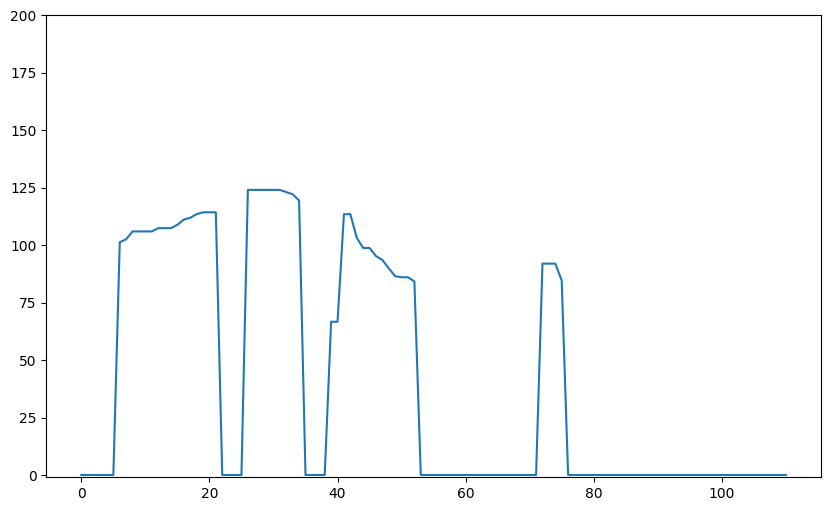

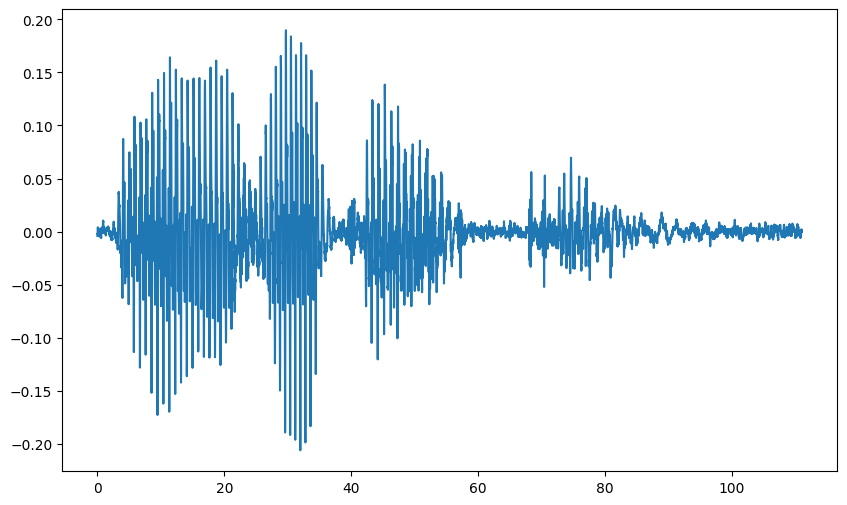

In [120]:
## 각 frame에서 해야할 일

"""
LPC 계수 측정하기
Pitch 측정하기 - voiced
Unvoiced 판단하기
"""
cutoff_freq = 900.0
sr = 16000
order = 10

file_path = "yonseicrop.wav"
yr,_ = lr.load(file_path,sr=sr)

## LPF to yr
lpf_coeff = scipy.signal.firwin(numtaps=101, cutoff=cutoff_freq, fs=sr, pass_zero='lowpass', window="hamming")
yr_lpf = scipy.signal.lfilter(lpf_coeff, 1.0, yr)

FE = utils.FrameExtractor(yr_lpf,win_len,hop_len)
# Pitch Detection 에서는 rectangular를 써야할 듯
frame_arr = FE.extract_frames(win_type="rectangular")
ham_arr = FE.extract_frames(win_type="hamming")

i=0
pitchlist = []
## 20번 frame을 예로 들어봅시다
for i, signal in enumerate(frame_arr[:]):   
    # signal = frame_arr[30]
    ### Frame에서 진행하는 Pitch Detection

    # plt.plot(signal)
    # plt.show()
    # if i==5:
    #     break
    # i+=1
    
    ## Frame 에서 LPC 계수 계산하기
    coeff = LPC(signal, order=order)

    voiced_flag, pitch = PitchDetector(signal, sr)
    if pitch: 
        print(i, "pitch: {}".format(pitch))
    pitchlist.append(pitch)
    
    ## 20번 frame의 신호를 정확하게 reconstruct 해볼까요?

# meidanfiltering to pitchlist
pitchlist = scipy.signal.medfilt(pitchlist, kernel_size=5)

plt.figure(figsize=(10,6))
plt.plot(pitchlist)
plt.ylim(-1,200)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,len(frame_arr),len(yr)), yr)
plt.show()


rectangular
From 18000 samples, total 111 frames are generated
294 pitch: 105.96026490066225


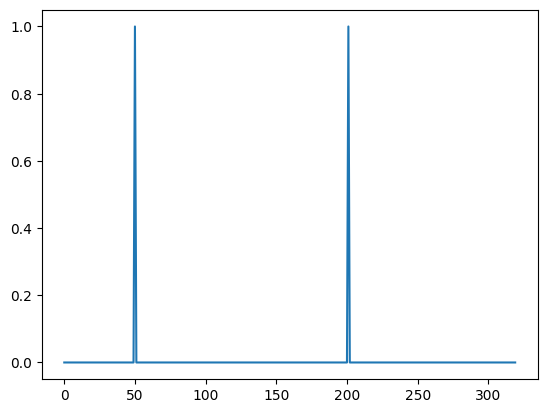

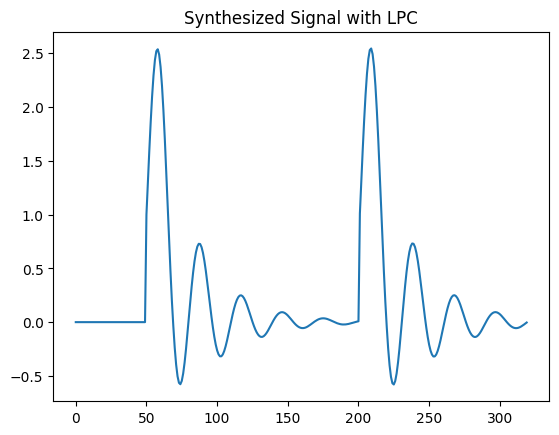

[ 1.29647903 -0.09402888 -0.07734083 -0.06192693 -0.04800979 -0.03557964
 -0.02471017 -0.01551363 -0.00799227 -0.00201982  0.00249802  0.00558392
  0.00742383  0.00833289  0.00841996  0.00791242  0.00708803  0.00616491
  0.00535105 -0.0167995 ]


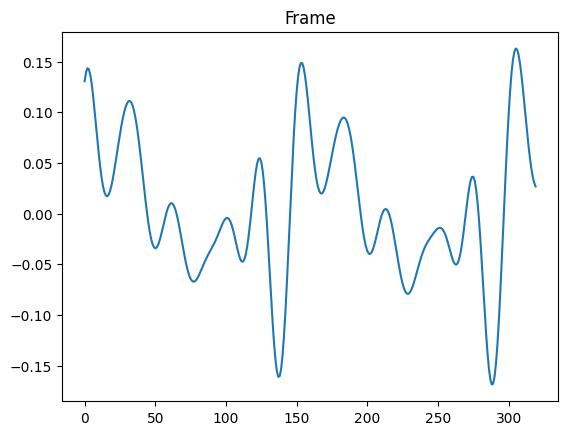

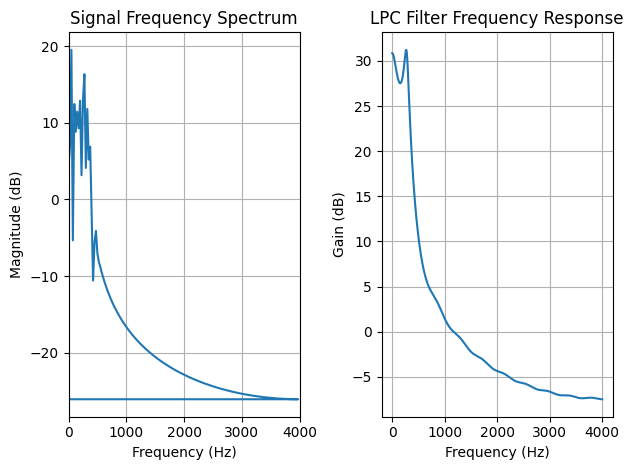

In [136]:
## Reconstruction 20번 frame
## 각 frame에서 해야할 일

"""
LPC 계수 측정하기
Pitch 측정하기 - voiced
Unvoiced 판단하기
"""
cutoff_freq = 900.0
sr = 16000
order = 20

file_path = "yonseicrop.wav"
yr,_ = lr.load(file_path,sr=sr)

## LPF to yr
lpf_coeff = scipy.signal.firwin(numtaps=101, cutoff=cutoff_freq, fs=sr, pass_zero='lowpass', window="hamming")
yr_lpf = scipy.signal.lfilter(lpf_coeff, 1.0, yr)
FE = utils.FrameExtractor(yr_lpf,win_len,hop_len)

# Pitch Detection 에서는 rectangular를 써야할 듯
frame_arr = FE.extract_frames(win_type="rectangular")
signal = frame_arr[10]

# Pitch
voiced_flag, pitch = PitchDetector(signal, sr)
if pitch: 
    print(i, "pitch: {}".format(pitch))
    
## Frame 에서 LPC 계수 계산하기
## 뽑아낸 피치 : 115 을 이용해서 impulse를 구축해볼까?
# 8ms 단위의 impulse
# 139 샘플?

coeff = LPC(signal, order=order)

if pitch: 
    duration = 0.008  # impulse 간격(초), 예시로 8ms
    samples_per_impulse = int(sr / pitch)
    
    # Impulse Train 초기화, 길이를 window_length로 설정
    impulse_train = np.zeros(len(signal))

    # 각 펄스 위치에 1 설정
    for i in range(0, len(signal), samples_per_impulse):
        if i+50 < len(signal):
            impulse_train[i+50] = 1

    plt.plot(impulse_train)
    plt.show()

    # LPC 계수 (여기서는 예시로 사용, 실제 계산 필요)
    lpc_coeff = np.concatenate(([1],-coeff))

    # LPC 필터를 사용한 신호 합성
    synthesized_signal = scipy.signal.lfilter([1.0], lpc_coeff, impulse_train)

    # 결과 확인
    plt.plot(synthesized_signal)
    plt.title("Synthesized Signal with LPC")
    plt.show()

    print(coeff)
    # filtered = lfilter(coeff,[1],signal)

plt.plot(signal)
plt.title("Frame")
plt.show()


# 신호의 스펙트럼 플롯
signal_fft = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal_fft), 1/fs)
w, h = scipy.signal.freqz([1], lpc_coeff, worN=8000, fs=fs)

plt.subplot(1, 2, 1)
plt.plot(freqs, 20 * np.log10(np.abs(signal_fft)), label='Original Signal Spectrum')
plt.title('Signal Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, fs/2)
plt.grid(True)

# LPC 필터의 주파수 응답 플롯
plt.subplot(1, 2, 2)
plt.plot(w, 20 * np.log10(np.abs(h)), label='LPC Filter Frequency Response')
plt.title('LPC Filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(True)

plt.tight_layout()
plt.show()